In [44]:
# Importation des packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro, pearsonr

In [2]:
# Importation des données
df = pd.read_csv("./data_raw/2_redondance_acp.csv")
df.head()

,X,Y,Z
0,1.764052,2.874841,0.800703
1,0.400157,1.629380,1.312686
2,0.978738,1.898394,0.730782
3,2.240893,4.141697,1.948425
4,1.867558,4.068308,1.919557


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       300 non-null    float64
 1   Y       300 non-null    float64
 2   Z       300 non-null    float64
dtypes: float64(3)
memory usage: 7.2 KB


In [4]:
df.shape

(300, 3)

In [5]:
df.describe()

,X,Y,Z
count,300.000000,300.000000,300.000000
mean,0.027530,-0.013656,-0.060302
std,1.002373,2.081115,1.149840
min,-2.772593,-6.460056,-3.813738
25%,-0.672929,-1.391416,-0.797139
50%,0.024655,0.097679,-0.046763
75%,0.683650,1.232074,0.728762
max,2.383145,5.204206,2.667921


In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
df.isnull().sum()

X    0
Y    0
Z    0
dtype: int64

# Analyse univariée

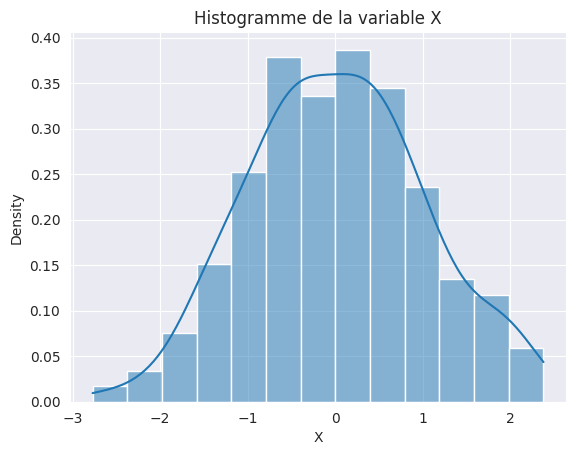

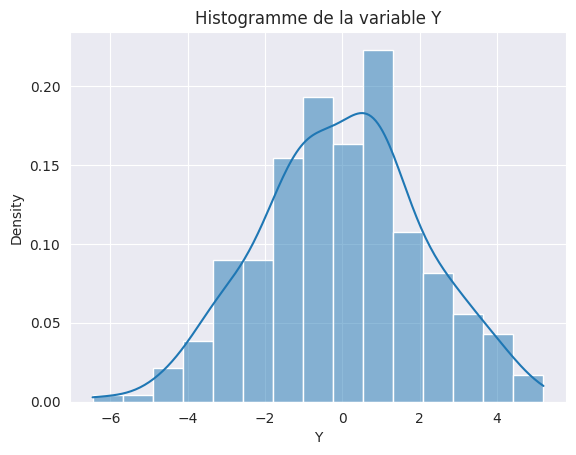

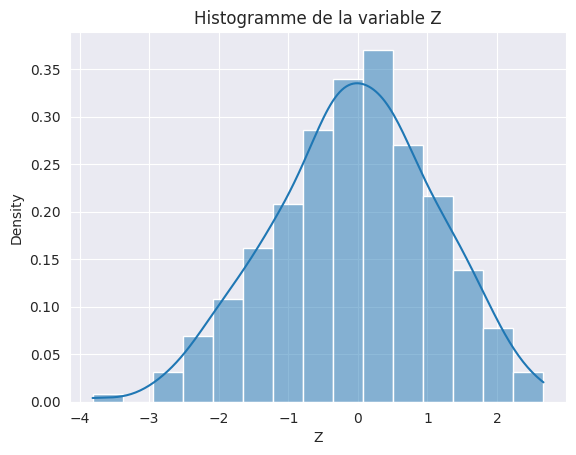

In [10]:
for column in df.columns :
    plt.title(f"Histogramme de la variable {column}")
    sns.histplot(df[column], kde=True, stat="density")
    plt.show()

Nos trois variables ont l'allure d'une distribution normale

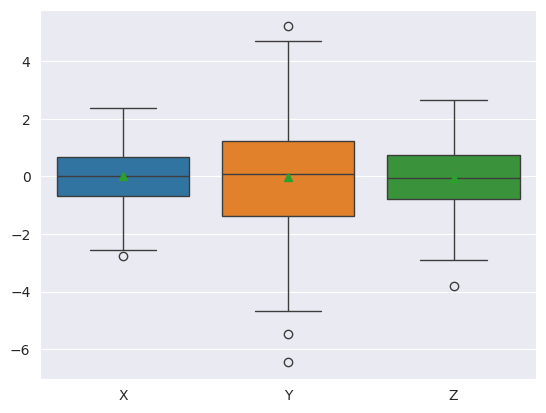

In [14]:
sns.boxplot(df, showmeans=True)
plt.show()

Nos variables ont une répartition centrée autour de 0 et la variable `Y` est plus étirée que `X` et `Y`

## Test de normalité

Hypothèse nulle H0 : Nos variables suivent une loi normale

Hypothèse alternative H1 : Nos variables ne suivent pas une loi normale

In [15]:
for column in df.columns :
    stat, p_value = shapiro(df[column])
    print(f"Variable {column} => \tStatistic : {stat}\t P value : {p_value}")

Variable X => 	Statistic : 0.994286213783389	 P value : 0.3221868498756976
Variable Y => 	Statistic : 0.9967389725528134	 P value : 0.8036941097702219
Variable Z => 	Statistic : 0.9949335046046159	 P value : 0.42882544188080796


Nos trois variables suivent belles et bien une loi normale. On pourra donc utiliser des tests paramétriques pour la suite

# Analyse Bivariée

In [22]:
matrix_corr = df.corr(method="pearson")
matrix_corr

,X,Y,Z
X,1.000000,0.970667,0.877342
Y,0.970667,1.000000,0.959821
Z,0.877342,0.959821,1.000000


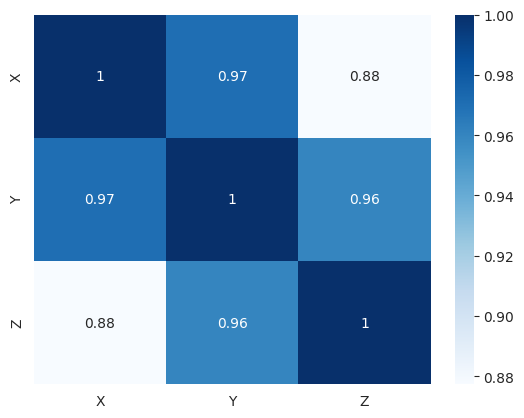

In [30]:
sns.heatmap(matrix_corr, annot=True, cmap=sns.color_palette("Blues", as_cmap=True))
plt.show()

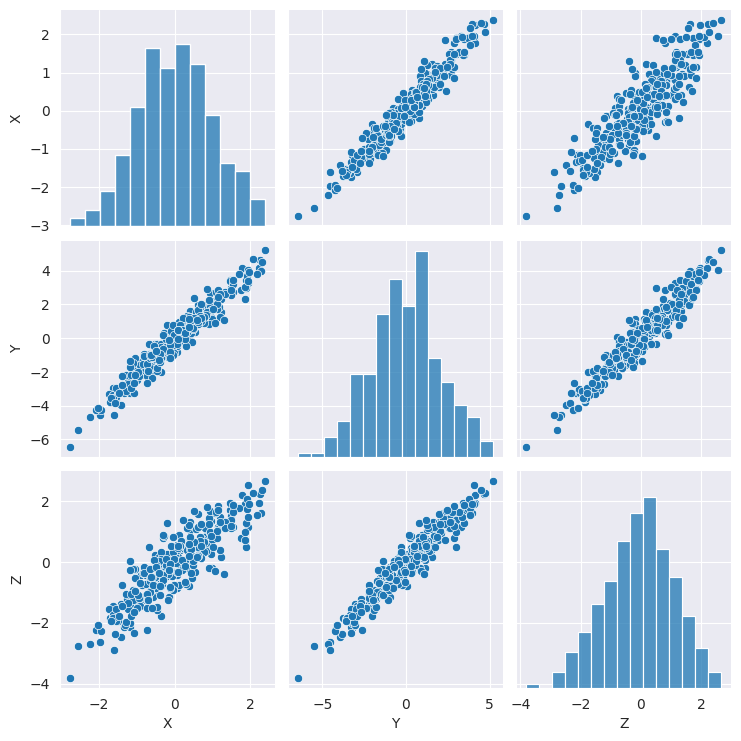

In [31]:
sns.pairplot(df)
plt.show()

Toutes nos variables semblent fortement et positivement liées entre elles. Il s'agit d'une liaison linéaire. Nous procéderons utliserons le test de pearson

In [34]:
stat, p_value = pearsonr(df.X, df.Y)
print(f"X & Y => \t Statistic : {stat} \t p value : {p_value}")

stat, p_value = pearsonr(df.X, df.Z)
print(f"X & Z => \t Statistic : {stat} \t p value : {p_value}")

stat, p_value = pearsonr(df.Z, df.Y)
print(f"Z & Y => \t Statistic : {stat} \t p value : {p_value}")

X & Y => 	 Statistic : 0.9706671331554683 	 p value : 1.62370955728221e-186
X & Z => 	 Statistic : 0.877342020411246 	 p value : 4.948899214988869e-97
Z & Y => 	 Statistic : 0.9598213176403873 	 p value : 1.6510738774058952e-166


Existence d'une forte liaison positive entre nos variables confirmées.

# Analyse en Composantes Principales (ACP)

In [65]:
def correlation_graph(pca,
                      x_y,
                      features) :
    """Affiche le graphe des correlations

    Positional arguments :
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante :
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0,
                pca.components_[x, i],
                pca.components_[y, i],
                head_width=0.07,
                head_length=0.07,
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])

    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)
def display_factorial_planes(   X_projected,
                                x_y,
                                pca=None,
                                labels = None,
                                clusters=None,
                                alpha=1,
                                figsize=[10,8],
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments :
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments :
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8]
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize:
        figsize = (7,6)

    # On gère les labels
    if  labels is None :
        labels = []
    try :
        len(labels)
    except Exception as e :
        raise e

    # On vérifie la variable axis
    if not len(x_y) ==2 :
        raise AttributeError("2 axes sont demandées")
    if max(x_y )>= X_.shape[1] :
        raise AttributeError("la variable axis n'est pas bonne")

    # on définit x et y
    x, y = x_y

    # Initialisation de la figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters

    # Les points
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha,
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe
    if pca :
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else :
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) :
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center')

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()


In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

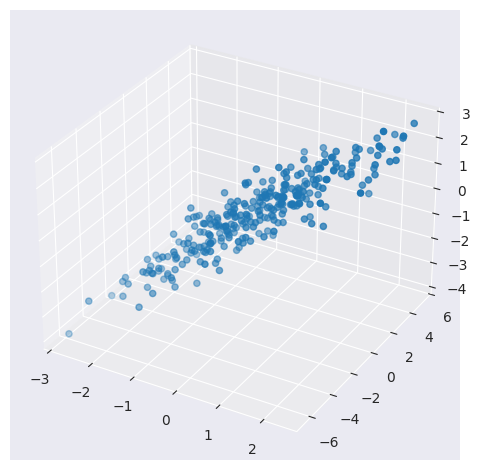

In [94]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(df.X, df.Y, df.Z, marker="o")
plt.tight_layout()
plt.show()

In [40]:
# Séparation des données
index = df.index
column = df.columns
X = df.values

In [42]:
# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled[:5]

array([[1.73530578, 1.390276  , 0.75005589],
       [0.37236649, 0.79081719, 1.19606482],
       [0.95054178, 0.92029764, 0.68914512],
       [2.21181245, 2.00003231, 1.74988177],
       [1.83873888, 1.96470874, 1.7247339 ]])

In [43]:
n_components = 3

In [47]:
pca = PCA(n_components=n_components)
pca.fit(X_scaled)

,n_components,3
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [56]:
explained_var = pca.explained_variance_ratio_
cumul_var = np.cumsum(explained_var)
cumul_var

array([0.95749777, 0.99848967, 1.        ])

In [54]:
f_list = list(range(1, n_components+1))
f_list

[1, 2, 3]

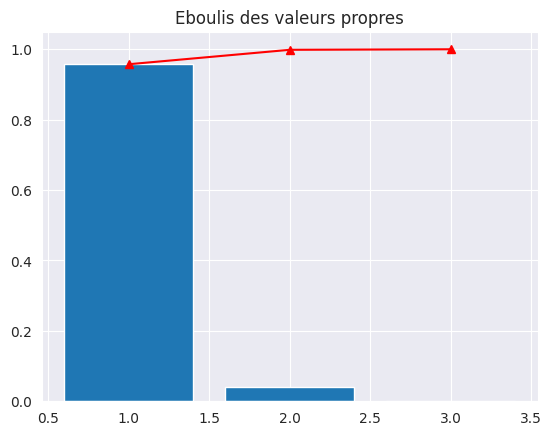

In [55]:
# Visualisation

plt.title("Eboulis des valeurs propres")
plt.bar(f_list, explained_var)
plt.plot(f_list, cumul_var, marker="^", c="red")
plt.show()

Nos deux premiers axes factoriels représentent 99.85 % de la variance

In [57]:
pcs = pca.components_

In [60]:
pcs_df = pd.DataFrame(pcs, columns=column, index=[f"F{i+1}" for i in range(n_components)])
pcs_df.transpose()

,F1,F2,F3
X,0.572550,-0.683373,-0.452978
Y,0.589092,-0.041371,0.807006
Z,0.570226,0.728897,-0.378882


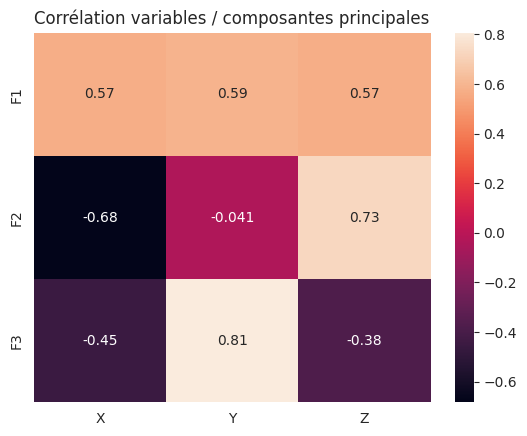

In [62]:
plt.title("Corrélation variables / composantes principales")
sns.heatmap(pcs_df, annot=True)
plt.show()

### Graphe des corrélations

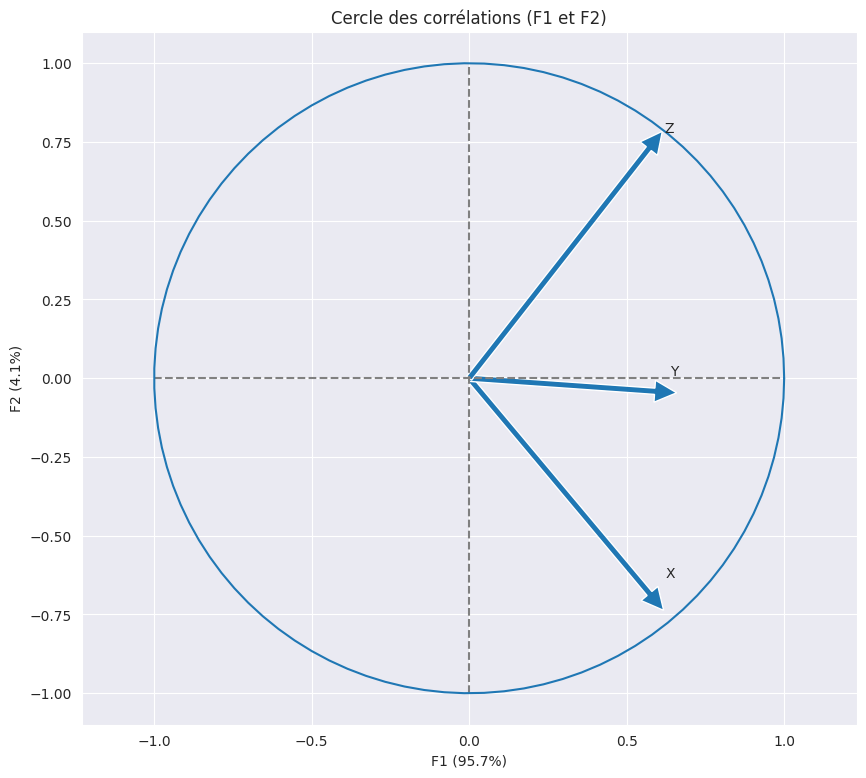

In [66]:
correlation_graph(pca, (0, 1), column)

In [64]:
X_proj = pca.transform(X_scaled)
X_proj[:5]

array([[ 2.24025025, -0.69666404,  0.05172403],
       [ 1.36108959,  0.58462584,  0.01635296],
       [ 1.47934064, -0.18533209,  0.05100702],
       [ 3.44240322, -0.31875204, -0.05086199],
       [ 3.1936513 , -0.08067259,  0.09915372]])

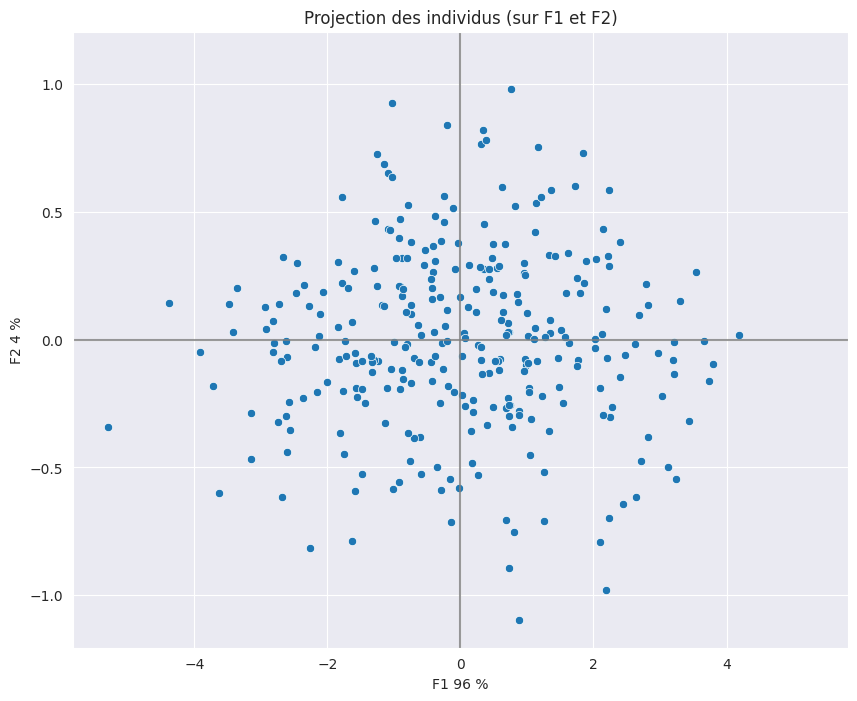

In [68]:
display_factorial_planes(X_proj, (0, 1), pca)

# Classification Hiérarchique

In [69]:
from scipy.cluster.hierarchy import linkage, fcluster

In [74]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(Z, labels=None,
                    figsize=(30, 15),
                    title="Hierarchical Clustering Dendrogram",
                    x_label="Distances", y_label="Clusters",
                    orientation="top" ) :
    """
    Affiche un dendrogramme horizontal à partir d'une matrice de linkage déjà calculée

    Paramètres :
    ------------
    Z : array-like
        Matrice de linkage obtenue via scipy.cluster.hierarchy.linkage.
    labels : list ou None
        Noms à afficher sur les feuilles du dendrogramme.
    figsize : tuple
        Taille de la figure (largeur, hauteur).
    title : str
        Titre du graphique
    orientation : str
        Orientation du dendogramme.
    """

    fig, ax = plt.subplots(1, 1, figsize=figsize)

    dendrogram(
        Z,
        ax=ax,
        labels=labels,
        orientation=orientation,
        leaf_font_size=15
    )

    plt.title(title, fontsize=16)
    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    ax.tick_params(axis='x', which='major', labelsize=15)
    ax.tick_params(axis='y', which='major', labelsize=15)

    plt.tight_layout()
    plt.show()

In [70]:
Z = linkage(X_scaled, method="ward", metric="euclidean")
Z[:5]

array([[1.20000000e+02, 1.38000000e+02, 2.51727746e-02, 2.00000000e+00],
       [1.20000000e+01, 2.12000000e+02, 3.57718065e-02, 2.00000000e+00],
       [9.50000000e+01, 1.28000000e+02, 3.71230613e-02, 2.00000000e+00],
       [7.40000000e+01, 2.33000000e+02, 3.84811446e-02, 2.00000000e+00],
       [1.73000000e+02, 1.82000000e+02, 4.20579239e-02, 2.00000000e+00]])

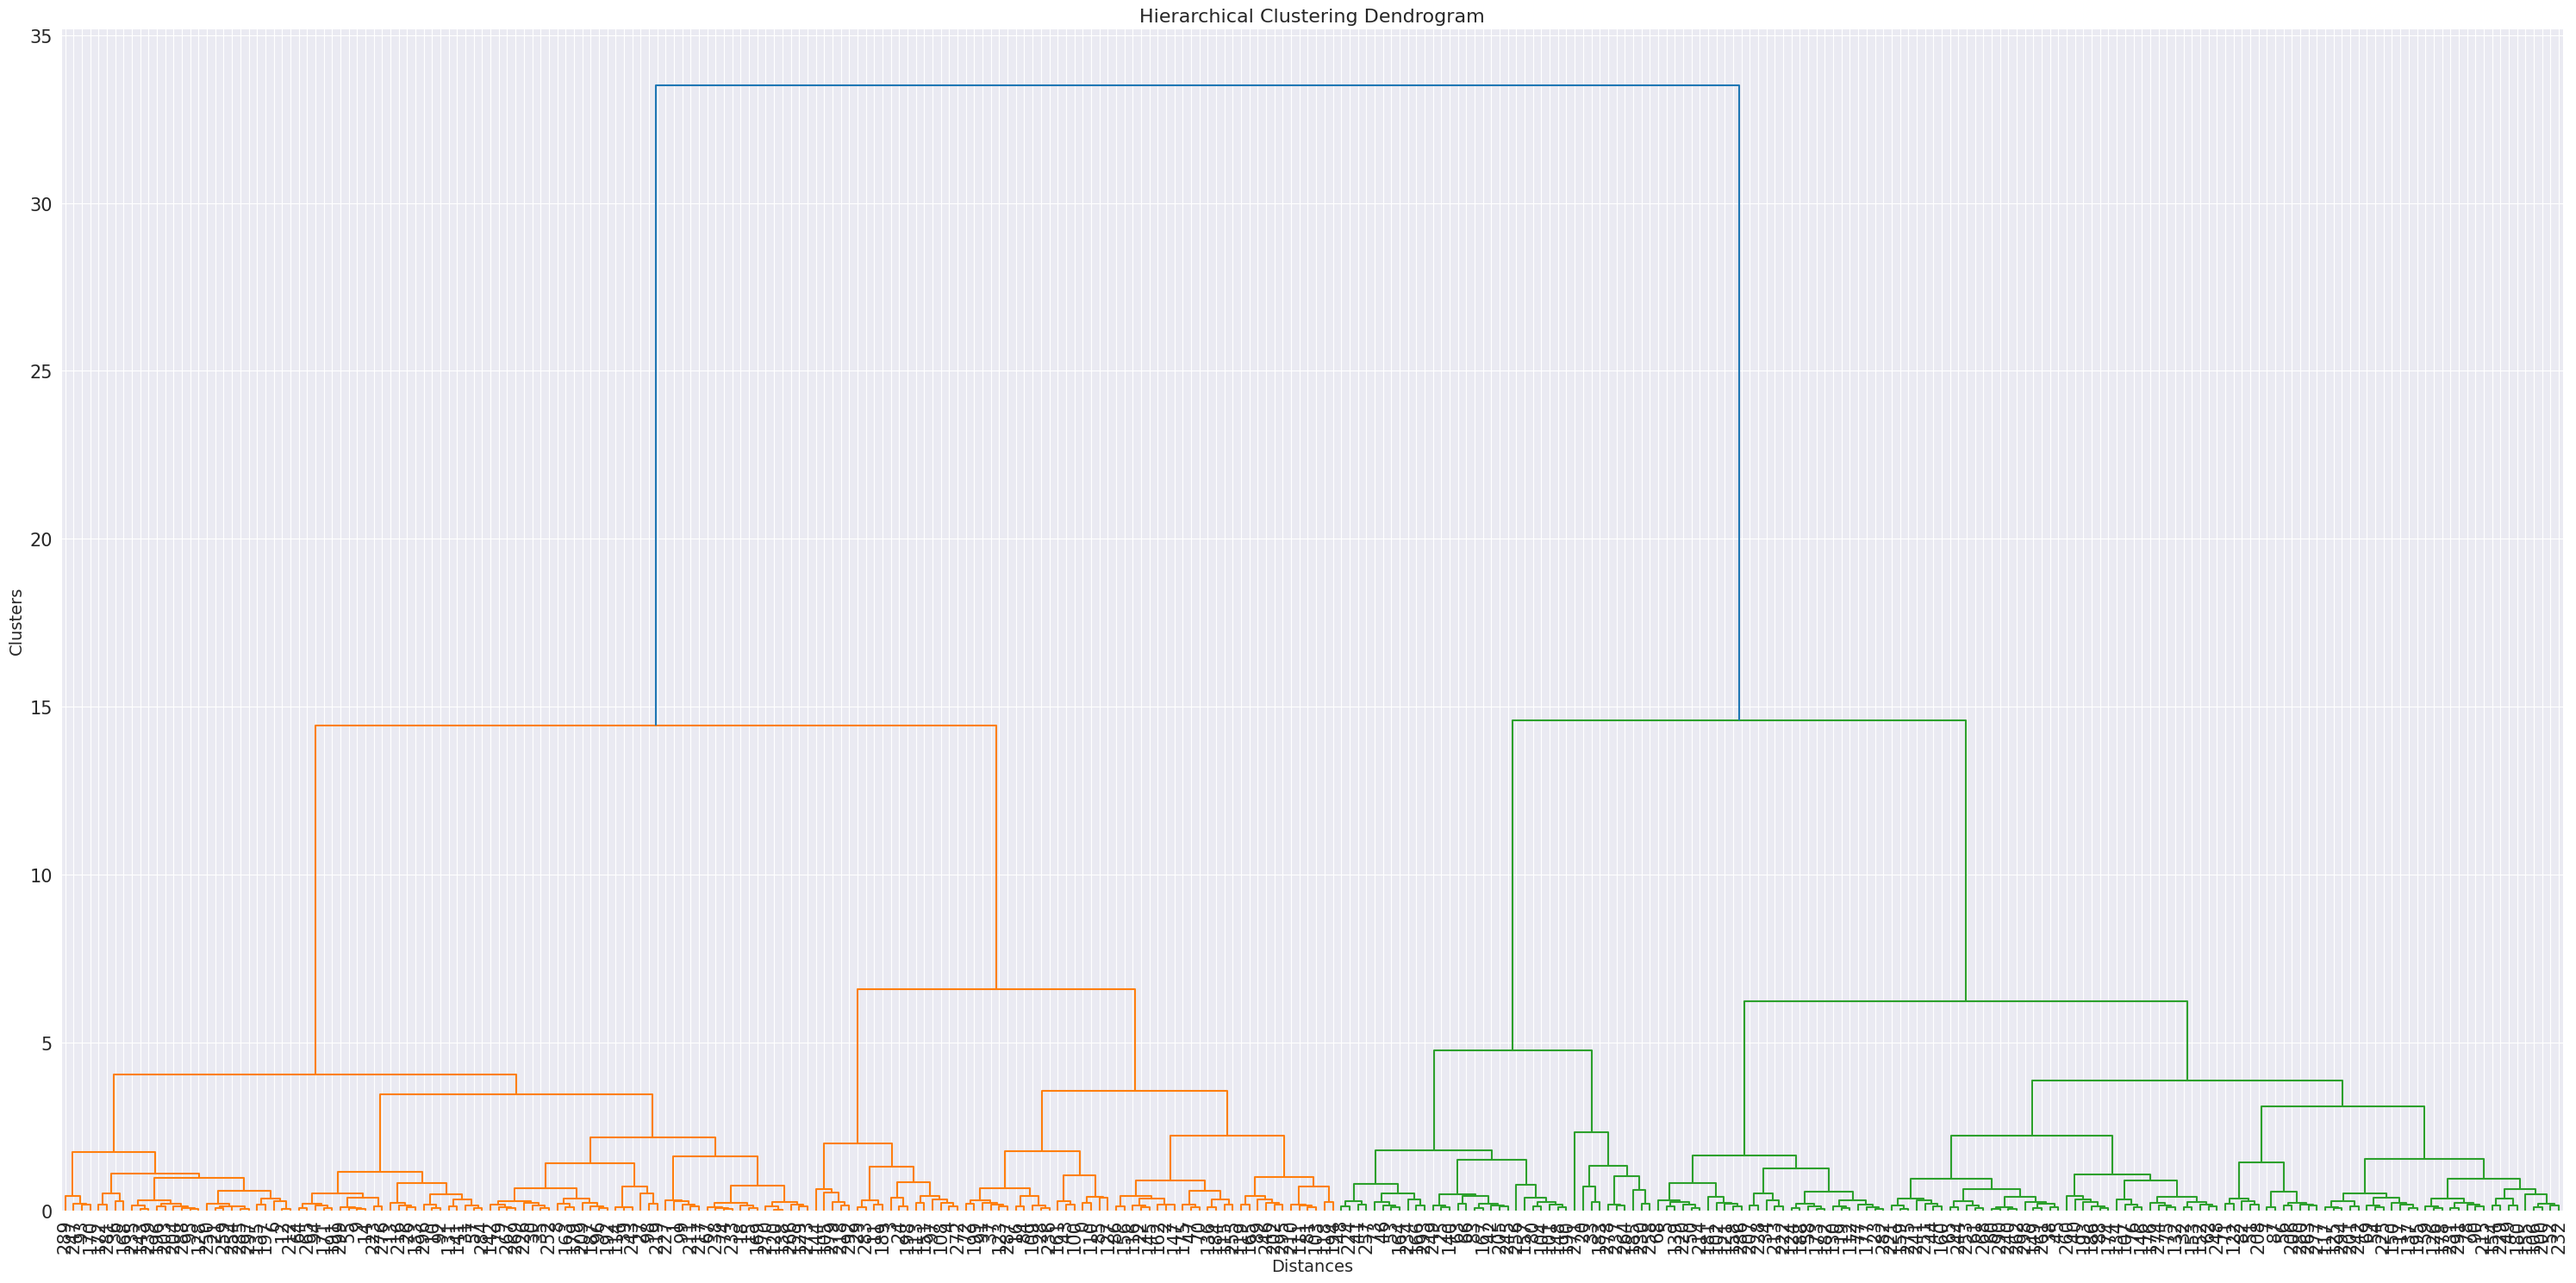

In [75]:
plot_dendrogram(Z, labels=index)

In [76]:
from sklearn.metrics import silhouette_score

# Choix du nombre de clusters

max_clusters = 10
silhouette_scores = []

for i in range(2, max_clusters+1) :
    clusters = fcluster(Z, t=i, criterion="maxclust")
    silhouette_avg = silhouette_score(X_scaled, clusters)
    silhouette_scores.append(silhouette_avg)

silhouette_scores

[0.5158368227053343,
 0.4557346426677706,
 0.4445601255067989,
 0.42392649988027903,
 0.36834010394266575,
 0.3756260874676524,
 0.324712953235235,
 0.315211261338598,
 0.3110967421450373]

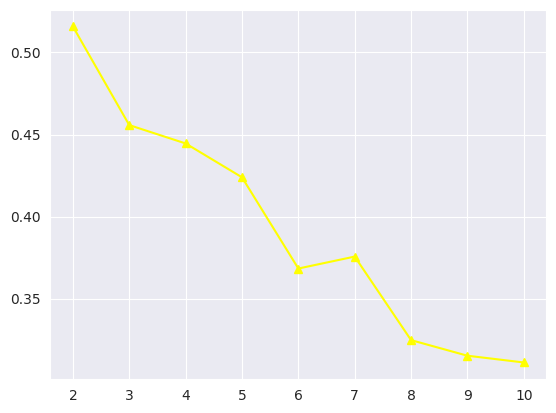

In [77]:
# Visualisation

plt.plot(range(2, max_clusters+1), silhouette_scores, marker="^", color="yellow")
plt.show()

Nous prendrons 4 clusters.

In [78]:
n_clusters = 4

In [79]:
clusters = fcluster(Z, t=n_clusters, criterion="maxclust")
df["cluster"] = clusters

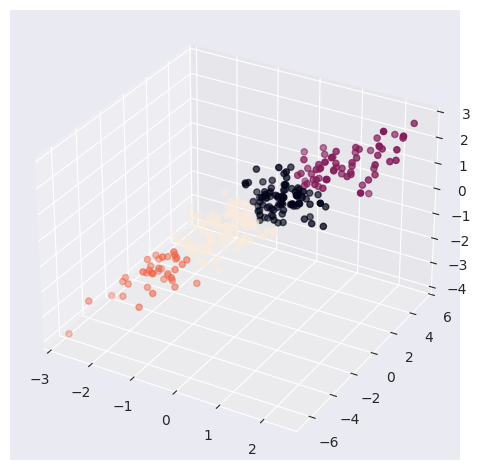

In [93]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df.X, df.Y, df.Z, c=df.cluster)
plt.tight_layout()
plt.show()